In [86]:
import sys

# for saving the pipeline
import joblib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [106]:
## importar el script preprocessors
sys.path.append('./preprocessors.py')

import preprocessors as pp

ModuleNotFoundError: No module named 'src'

In [88]:
X_train = pd.read_csv("../data/02_model_input/train.csv")

# Configuration

In [89]:
DUPLICATED_VARS = ["status_id"]
NUM_VARS = ["num_reactions", "num_comments", "num_shares", "num_likes", "num_loves", "num_wows", "num_hahas", "num_sads", "num_angrys"]
DATE_COL = ["status_published"]
ID_COL = ["status_id"]
CAT_VARS = ["status_type"]
DROP_VARS = ["status_id", "status_published"]
FEATURES = ['num_angrys', 'num_sads', 'num_hahas', 'num_wows', 'num_loves', 
            'num_shares', 'hour', 'num_comments', 'num_likes', 'num_reactions',
            'status_type_photo', 'status_type_link', 'status_type_status', 'status_type_video']

In [90]:
facebook_pipe = Pipeline([
    ('drop_duplicates', pp.DropDuplicates(DUPLICATED_VARS)),
    ('date_transformer', pp.DateTransformer(DATE_COL)),
    ('cat_encoder',pp.CategoricalEncoder(CAT_VARS)),
    ('drop_features', pp.DropFeatures(DROP_VARS)),
    ('feature_selector', pp.SelectFeatures(FEATURES)),
    ('scaler', pp.Scaler()),
    ('kmeans', KMeans(n_clusters=4, random_state=1961))
])

In [91]:
result_adjust_pipe = Pipeline([
    ('drop_duplicates', pp.DropDuplicates(DUPLICATED_VARS)),
    ('date_transformer', pp.DateTransformer(DATE_COL)),
    ('cat_encoder',pp.CategoricalEncoder(CAT_VARS)),
])

In [92]:
cluster = facebook_pipe.fit_predict(X_train)

In [93]:
X_train_new = result_adjust_pipe.fit_transform(X_train)

In [94]:
X_train_new = X_train_new[FEATURES]
X_train_new.loc[:, "Cluster"] = cluster

sum_groups = X_train_new.groupby("Cluster").sum()

In [97]:
sum_groups

,num_angrys,num_sads,num_hahas,num_wows,num_loves,num_shares,hour,num_comments,num_likes,num_reactions,status_type_photo,status_type_link,status_type_status,status_type_video
Cluster,,,,,,,,,,,,,,
0,39,88,242,195,6017,15145,5745,139265,54779,61360,0.0,16.0,0.0,246.0
1,159,484,648,2352,5156,8278,31001,50247,650792,659601,3828.0,0.0,0.0,0.0
2,490,777,3413,5011,69975,232138,9812,1232431,457664,537336,0.0,0.0,0.0,1847.0
3,5,114,34,400,524,1032,2993,12038,150764,151841,0.0,42.0,318.0,0.0


In [95]:
def plot_variables(df, vars):
    num_subplots = len(vars)
    rows = (num_subplots + 1) // 2  # Calculate the number of rows for subplots
    
    fig, axes = plt.subplots(rows, 2, figsize=(12, 6 * rows // 2+10))
    axes = axes.flatten()
    
    if num_subplots % 2 != 0:
        fig.delaxes(axes[-1]) 
        
    for i, var in enumerate(vars): 
        sns.barplot(data=df, x=df.index, y=var, hue=df.index, 
                    palette="Spectral", ax=axes[i])
        axes[i].set_title(var)
        
    plt.tight_layout()

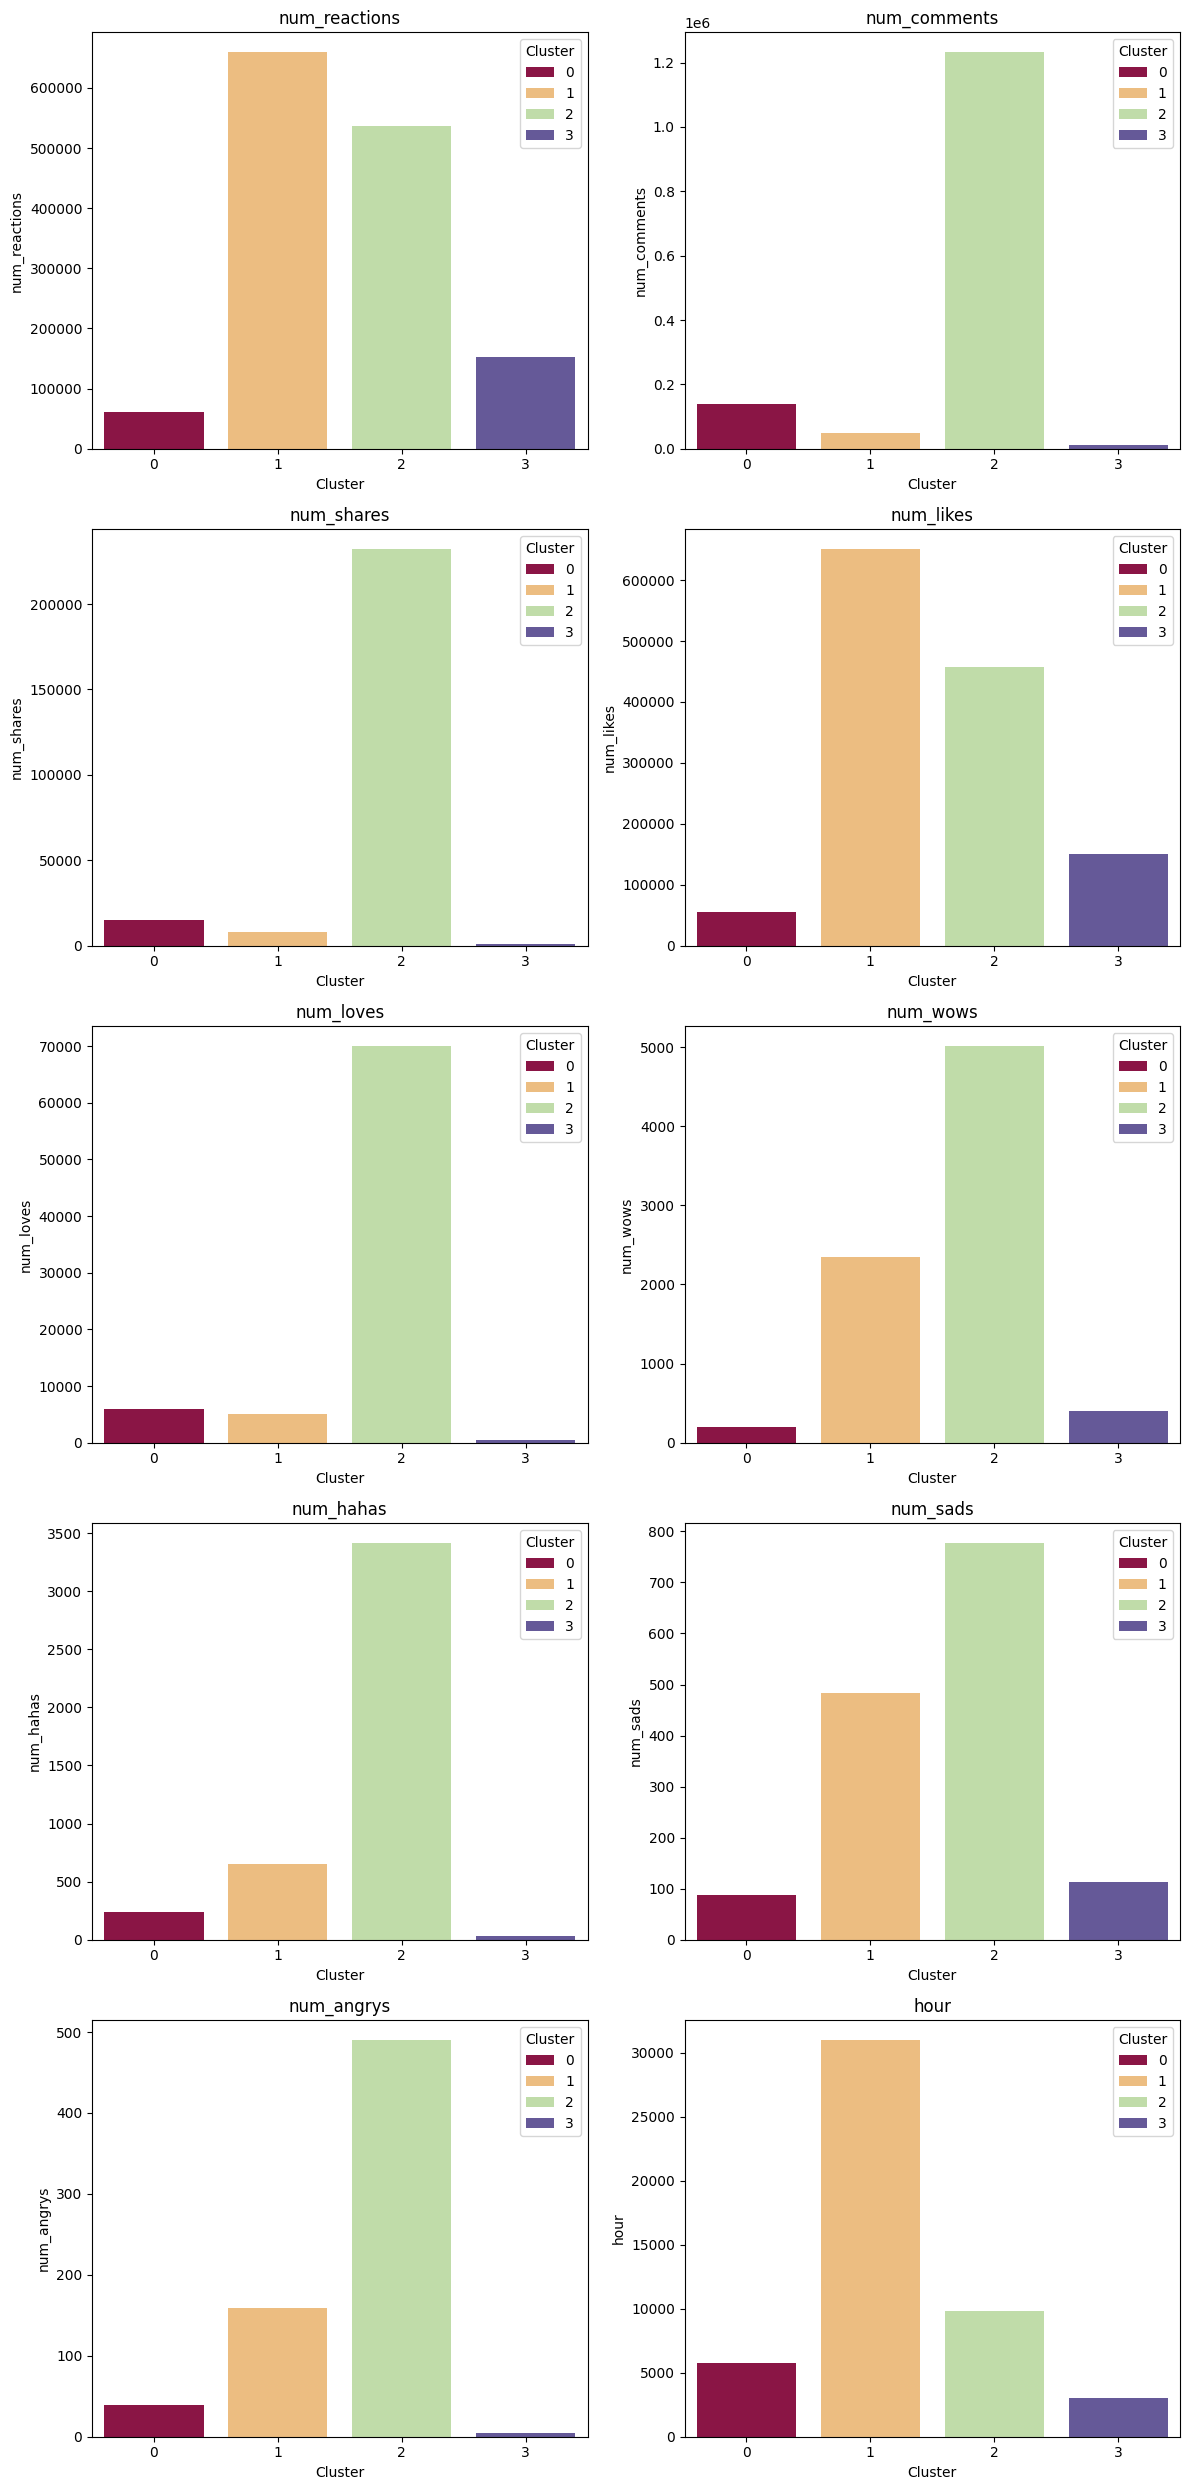

In [96]:
plot_variables(sum_groups, NUM_VARS+["hour"])

# Score new data

In [79]:
X_test = pd.read_csv('../data/02_model_input/test.csv')

In [81]:
test_clusters = facebook_pipe.fit_predict(X_test)
X_test_new = result_adjust_pipe.fit_transform(X_test)

In [99]:
X_test_new = X_test_new[FEATURES]
X_test_new.loc[:, "Cluster"] = test_clusters

test_groups = X_test_new.groupby("Cluster").sum()

In [101]:
test_groups

,num_angrys,num_sads,num_hahas,num_wows,num_loves,num_shares,hour,num_comments,num_likes,num_reactions,status_type_photo,status_type_link,status_type_status,status_type_video
Cluster,,,,,,,,,,,,,,
0,60,101,393,495,6844,22700,1709,126862,57648,65541,0.0,0.0,0.0,238.0
1,22,48,141,228,539,2134,1714,14618,60835,61816,352.0,0.0,0.0,0.0
2,4,15,7,38,46,60,343,1347,23758,23868,0.0,2.0,43.0,0.0
3,8,5,6,66,91,206,1510,1048,17618,17794,67.0,3.0,0.0,0.0


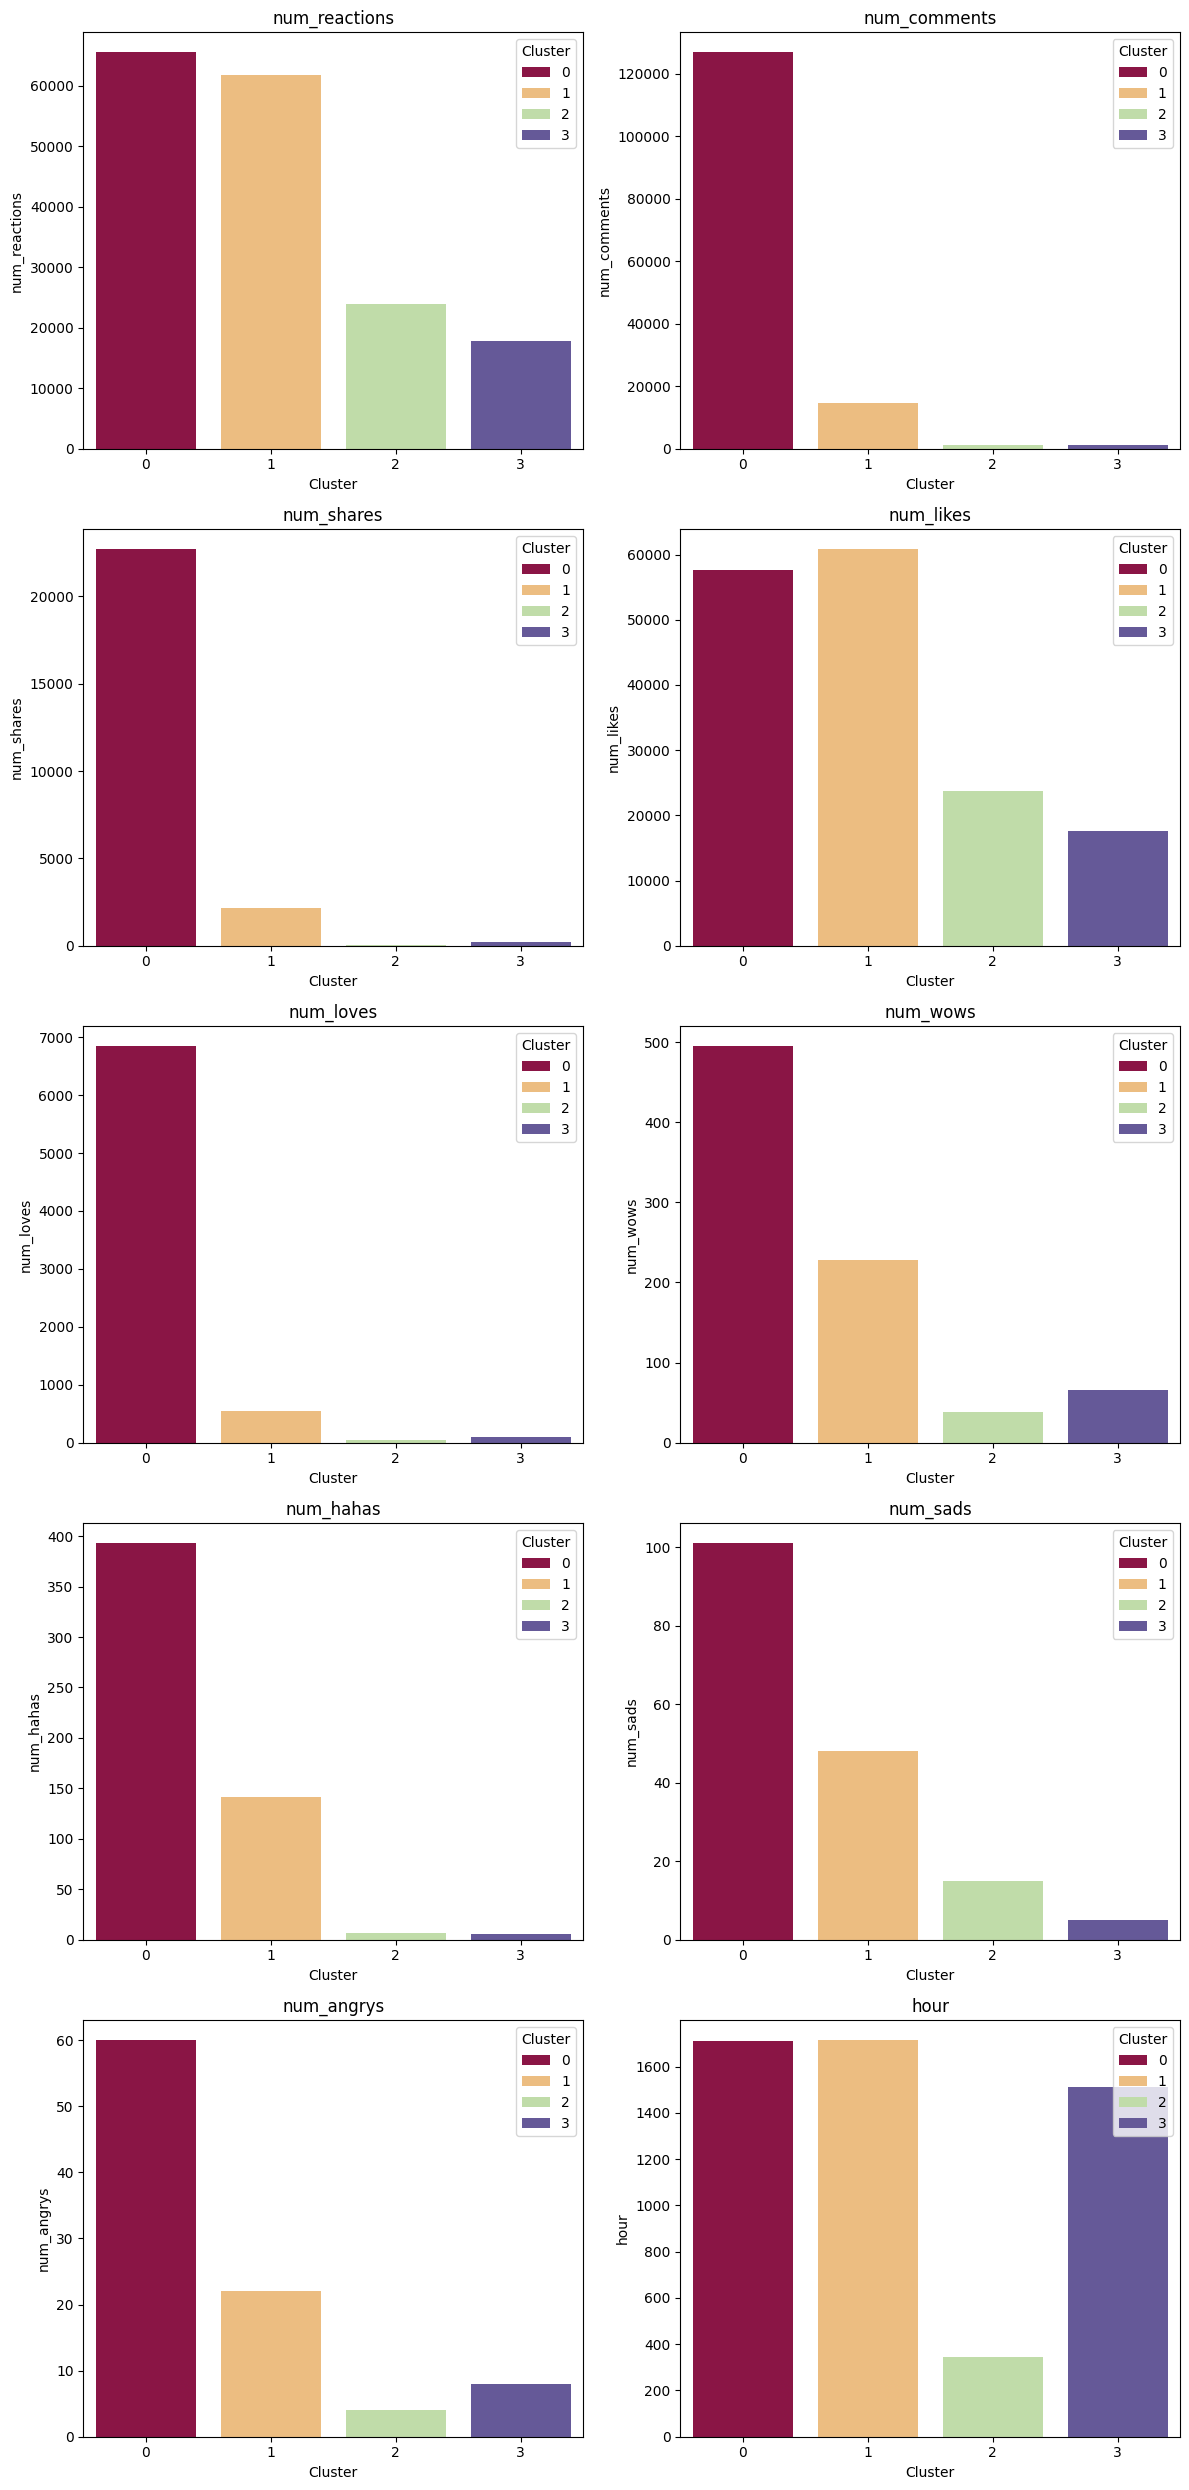

In [103]:
plot_variables(test_groups, NUM_VARS+["hour"])

### Most videos of the test data are not viral
### Viral photos are separated from the rest
### Links are groups together. The hour os these status are done at early hours.

In [105]:
X_test = pd.read_csv('../data/02_model_input/test.csv')

joblib.dump(facebook_pipe, '../data/03_models/facebook_predict_pipeline.joblib')
joblib.dump(result_adjust_pipe, '../data/03_models/facebook_preprocess_pipeline.joblib')

['../data/03_models/facebook_preprocess_pipeline.joblib']